# Result for **FullConnect+MNIST**
### This notebook is for seed $42$. The results in the paper are the average of $5$ times with seeds in $[1, 19, 31, 42, 80]$

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import os
import random
import numpy as np
import pandas as pd
import copy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

## Models

In [2]:
# MNIST Fully Connected Net ----------------------------------------------------
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MNISTNet_copy(nn.Module):
    def __init__(self):
        super(MNISTNet_copy, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Prepare data

In [3]:
def create_loaders(dataset_name, n_workers, batch_size):
    train_data, test_data = load_data(dataset_name)
    train_loader_workers = dict()
    n = len(train_data)
    
    # preparing iterators for workers
    indices = np.arange(n)
    np.random.shuffle(indices)
    a = np.int(np.floor(n / n_workers))
    top_ind = a * n_workers
    seq = range(a, top_ind, a)
    split = np.split(indices[:top_ind], seq)
    b = 0
    for ind in split:
        train_loader_workers[b] = DataLoader(Subset(train_data, ind), batch_size=batch_size, shuffle=True)
        b = b + 1
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader_workers, test_loader


def load_data(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)

    elif dataset_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_data = datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
        test_data = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    elif dataset_name == 'cifar100':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        train_data = datasets.CIFAR100(root='./data', train=True,
                                       download=True, transform=transform_train)
        test_data = datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test)

    else:
        raise ValueError(dataset_name + ' is not known.')

    return train_data, test_data

## Parameter and Setup

In [4]:
# Hyperparameters
RANDOM_SEED = 42
lr = 0.005
BATCH_SIZE = 10
NUM_EPOCHS = 20
NUM_WORKERS = 10
D = 10  # compute thread
h = 0.01  # sparse level 99%

if not os.path.exists('result'):
    os.mkdir('result')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cuda


## Functions

In [5]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
def evaluate_accuracy(model, data_iter, device):
    acc_sum, num_epo = 0.0, 0
    for image, label in data_iter:
        image, label = image.to(device), label.to(device)
        acc_sum += (model(image).argmax(dim=1) == label).float().sum().item()
        num_epo += label.shape[0]
    return acc_sum / num_epo * 100


# Top_k sparse
def prep_grad(x):
    x_flat = torch.unsqueeze(x, 0).flatten()
    dim = x.shape
    d = x_flat.shape[0]
    return x_flat, dim, d


def top_k_opt(x, h):
    """
    :param x: vector to sparsify
    :param h: density
    :return: compressed vector
    """
    x, dim, d = prep_grad(x)
    # number of coordinates kept
    r = int(np.maximum(1, np.floor(d * h)))
    # positions of top_k coordinates
    _, ind = torch.topk(torch.abs(x), r)
    mask = torch.zeros_like(x)
    mask[ind] = 1
    t = mask * x
    t = t.reshape(dim)
    return t


def compt(old, new):
    result = 0
    for i in range(len(old)):
        result += ((old[i].view(-1) - new[i].view(-1)) ** 2).sum().item()
    return result

# SASG

In [6]:
print("SASG  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
model_copy = MNISTNet_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'mnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)
                        grad_agg[p_id] += Tk_sparse
                        error_worker[w_id][p_id] = g - Tk_sparse
                        grad_worker[w_id][p_id] = Tk_sparse
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (2 * lr * (NUM_WORKERS ** 2))

            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()

                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1

                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()

                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()
                
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)

            if test_acc_it > 98.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

# save_csv
list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SASG-full.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SASG-full-iter.csv", encoding='gbk')

SASG  lr:0.005--h:0.01--epoch:20--worker:10
Number_parameter: 4
Element_parameter: 407050
Element_parameter_sparse: 4071


C:\Users\DxiaoG\AppData\Local\Temp\Mxt230\tmp\ipykernel_16296\1940885620.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.int(np.floor(n / n_workers))


Epoch: 001/020 | Batch 0100/0600 | Cost: 0.1529
Epoch: 001/020 | Batch 0200/0600 | Cost: 0.1443
Epoch: 001/020 | Batch 0300/0600 | Cost: 0.0752
Epoch: 001/020 | Batch 0400/0600 | Cost: 0.2091
Epoch: 001/020 | Batch 0500/0600 | Cost: 0.3044
Epoch: 001/020 | Batch 0600/0600 | Cost: 0.0168
epoch 1, skip_num 1776, loss 0.3814, train acc 89.473%, test acc 94.140%
Epoch: 002/020 | Batch 0100/0600 | Cost: 0.0135
Epoch: 002/020 | Batch 0200/0600 | Cost: 0.0962
Epoch: 002/020 | Batch 0300/0600 | Cost: 0.1066
Epoch: 002/020 | Batch 0400/0600 | Cost: 0.0248
Epoch: 002/020 | Batch 0500/0600 | Cost: 0.0627
Epoch: 002/020 | Batch 0600/0600 | Cost: 0.0940
epoch 2, skip_num 2643, loss 0.1741, train acc 95.177%, test acc 95.900%
Epoch: 003/020 | Batch 0100/0600 | Cost: 0.1766
Epoch: 003/020 | Batch 0200/0600 | Cost: 0.0101
Epoch: 003/020 | Batch 0300/0600 | Cost: 0.0127
Epoch: 003/020 | Batch 0400/0600 | Cost: 0.2294
Epoch: 003/020 | Batch 0500/0600 | Cost: 0.1370
Epoch: 003/020 | Batch 0600/0600 | Cos

# LASG

In [7]:
print("LASG  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
model_copy = MNISTNet_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'mnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]

para_list = []
Skip_epoch = []
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach()
                        grad_agg[p_id] += g
                        grad_worker[w_id][p_id] = g
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread / (2 * lr * (NUM_WORKERS ** 2))

            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()

                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1

                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach()
                            grad_agg[p_id] += g
                            grad_worker[w_id][p_id] = g
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()

                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)

            if test_acc_it > 98.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_Acc_epoch.append(train_acc_sum / num * 100)
        test_Acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"LASG-full.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"LASG-full-iter.csv", encoding='gbk')

LASG  lr:0.005--epoch:20--worker:10
Number_parameter: 4
Element_parameter: 407050


C:\Users\DxiaoG\AppData\Local\Temp\Mxt230\tmp\ipykernel_16296\1940885620.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.int(np.floor(n / n_workers))


Epoch: 001/020 | Batch 0100/0600 | Cost: 0.1977
Epoch: 001/020 | Batch 0200/0600 | Cost: 0.1746
Epoch: 001/020 | Batch 0300/0600 | Cost: 0.0873
Epoch: 001/020 | Batch 0400/0600 | Cost: 0.2772
Epoch: 001/020 | Batch 0500/0600 | Cost: 0.3600
Epoch: 001/020 | Batch 0600/0600 | Cost: 0.0149
epoch 1, skip_num 294, loss 0.3632, train acc 89.990%, test acc 94.040%
Epoch: 002/020 | Batch 0100/0600 | Cost: 0.0152
Epoch: 002/020 | Batch 0200/0600 | Cost: 0.0814
Epoch: 002/020 | Batch 0300/0600 | Cost: 0.0858
Epoch: 002/020 | Batch 0400/0600 | Cost: 0.0162
Epoch: 002/020 | Batch 0500/0600 | Cost: 0.0409
Epoch: 002/020 | Batch 0600/0600 | Cost: 0.0525
epoch 2, skip_num 1006, loss 0.1797, train acc 94.932%, test acc 95.720%
Epoch: 003/020 | Batch 0100/0600 | Cost: 0.1965
Epoch: 003/020 | Batch 0200/0600 | Cost: 0.0079
Epoch: 003/020 | Batch 0300/0600 | Cost: 0.0095
Epoch: 003/020 | Batch 0400/0600 | Cost: 0.2965
Epoch: 003/020 | Batch 0500/0600 | Cost: 0.1560
Epoch: 003/020 | Batch 0600/0600 | Cost

# Sparse

In [8]:
print("Sparse  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'mnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                    Tk_sparse = top_k_opt(g, h)
                    grad_agg[p_id] += Tk_sparse
                    error_worker[w_id][p_id] = g - Tk_sparse
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 98.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)
                
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        test_Acc_epoch.append(test_acc)
        train_Acc_epoch.append(train_acc_sum / num * 100)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"Sparse-full.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"Sparse-full-iter.csv", encoding='gbk')


Sparse  lr:0.005--h:0.01--epoch:20--worker:10
Number_parameter: 4
Element_parameter: 407050
Element_parameter_sparse: 4071


C:\Users\DxiaoG\AppData\Local\Temp\Mxt230\tmp\ipykernel_16296\1940885620.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.int(np.floor(n / n_workers))


Epoch: 001/020 | Batch 0100/0600 | Cost: 0.4800
Epoch: 001/020 | Batch 0200/0600 | Cost: 0.0425
Epoch: 001/020 | Batch 0300/0600 | Cost: 0.3939
Epoch: 001/020 | Batch 0400/0600 | Cost: 0.0813
Epoch: 001/020 | Batch 0500/0600 | Cost: 0.0598
Epoch: 001/020 | Batch 0600/0600 | Cost: 0.6510
epoch 1, loss 0.3864, train acc 89.370%, test acc 93.610%
Epoch: 002/020 | Batch 0100/0600 | Cost: 0.0298
Epoch: 002/020 | Batch 0200/0600 | Cost: 0.0271
Epoch: 002/020 | Batch 0300/0600 | Cost: 0.0463
Epoch: 002/020 | Batch 0400/0600 | Cost: 0.3004
Epoch: 002/020 | Batch 0500/0600 | Cost: 0.1828
Epoch: 002/020 | Batch 0600/0600 | Cost: 0.0712
epoch 2, loss 0.1861, train acc 94.672%, test acc 95.600%
Epoch: 003/020 | Batch 0100/0600 | Cost: 0.1315
Epoch: 003/020 | Batch 0200/0600 | Cost: 0.2533
Epoch: 003/020 | Batch 0300/0600 | Cost: 0.0933
Epoch: 003/020 | Batch 0400/0600 | Cost: 0.0190
Epoch: 003/020 | Batch 0500/0600 | Cost: 0.0099
Epoch: 003/020 | Batch 0600/0600 | Cost: 0.1527
epoch 3, loss 0.1346

# SGD

In [9]:
print("Dis-SGD  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = MNISTNet()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'mnist'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

Loss_epoch = []
train_Acc_epoch = []
test_Acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
flag_acc = False
for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    grad_agg[p_id] += lr * p.grad.data.clone().detach()
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 98.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_Acc_epoch.append(train_acc_sum / num * 100)
        test_Acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_Acc_epoch)
list_write.append(test_Acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SGD-full.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SGD-full-iter.csv", encoding='gbk')


Dis-SGD  lr:0.005--epoch:20--worker:10
Number_parameter: 4
Element_parameter: 407050


C:\Users\DxiaoG\AppData\Local\Temp\Mxt230\tmp\ipykernel_16296\1940885620.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.int(np.floor(n / n_workers))


Epoch: 001/020 | Batch 0100/0600 | Cost: 0.4416
Epoch: 001/020 | Batch 0200/0600 | Cost: 0.0554
Epoch: 001/020 | Batch 0300/0600 | Cost: 0.3806
Epoch: 001/020 | Batch 0400/0600 | Cost: 0.0773
Epoch: 001/020 | Batch 0500/0600 | Cost: 0.0561
Epoch: 001/020 | Batch 0600/0600 | Cost: 0.6288
epoch 1, loss 0.3640, train acc 90.072%, test acc 93.900%
Epoch: 002/020 | Batch 0100/0600 | Cost: 0.0277
Epoch: 002/020 | Batch 0200/0600 | Cost: 0.0303
Epoch: 002/020 | Batch 0300/0600 | Cost: 0.0368
Epoch: 002/020 | Batch 0400/0600 | Cost: 0.3117
Epoch: 002/020 | Batch 0500/0600 | Cost: 0.1939
Epoch: 002/020 | Batch 0600/0600 | Cost: 0.0610
epoch 2, loss 0.1820, train acc 94.795%, test acc 95.610%
Epoch: 003/020 | Batch 0100/0600 | Cost: 0.1187
Epoch: 003/020 | Batch 0200/0600 | Cost: 0.2347
Epoch: 003/020 | Batch 0300/0600 | Cost: 0.0930
Epoch: 003/020 | Batch 0400/0600 | Cost: 0.0165
Epoch: 003/020 | Batch 0500/0600 | Cost: 0.0086
Epoch: 003/020 | Batch 0600/0600 | Cost: 0.1568
epoch 3, loss 0.1319

## Plotting

original communication number: 1000


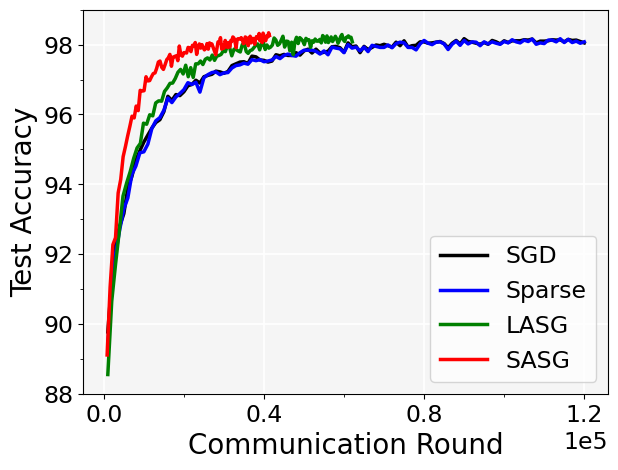

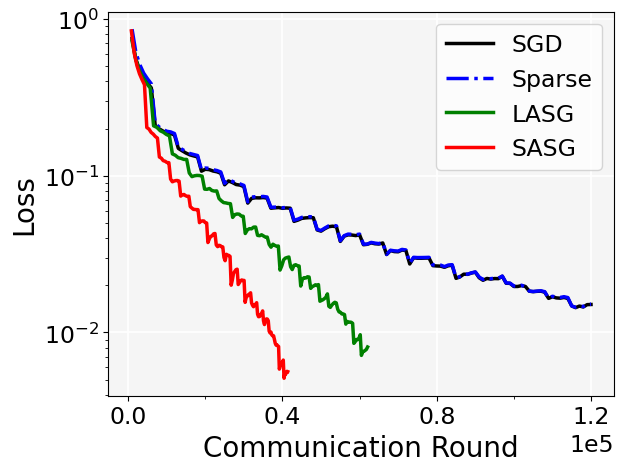

In [10]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

SASG_data = pd.read_csv("./result/"+"SASG-full-iter.csv")
LASG_data = pd.read_csv("./result/"+"LASG-full-iter.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-full-iter.csv")
sgd_data = pd.read_csv("./result/"+"SGD-full-iter.csv")

SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()

comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0
for i in range(len(SASG_skip)):
    comm_num_SASG += original_num
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    comm_round_SASG.append(comm_num_SASG - SASG_skip[i])
    comm_round_LASG.append(comm_num_LASG - LASG_skip[i])
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)

font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_round_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-')
plt.plot(comm_round_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(88, 99)
ymajorLocator = MultipleLocator(2)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(1)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"test_full.png", dpi=600)
plt.show()

plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5, linestyle='-')
plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5, linestyle='-.')
plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
ax = plt.gca()
xmajorLocator = MultipleLocator(40000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(20000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_full.png", dpi=600)
plt.show()